## **Preparation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install --upgrade moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 388 kB 3.9 MB/s 
     |████████████████████████████████| 26.9 MB 1.3 MB/s 
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110742 sha256=3c242e4af647f4976d800601f4ad9b1a7a6f7c76d07535b9ac76daa56e7e5ec1
  Stored in directory: /root/.cache/pip/wheels/e4/a4/db/0368d3a04033da662e13926594b3a8cf1aa4ffeefe570cfac1
Successfully built moviepy
  Attempting uninstall: moviepy
    Found existing installation: moviepy 0.2.3.5
    Uninstalling moviepy-0.2.3.5:
      Successfully uninstalled moviepy-0.2.3.5


In [ ]:
# only clone once!
! git clone https://github.com/kenshohara/video-classification-3d-cnn-pytorch.git

Cloning into 'video-classification-3d-cnn-pytorch'...
remote: Enumerating objects: 121, done.
remote: Total 121 (delta 0), reused 0 (delta 0), pack-reused 121
Receiving objects: 100% (121/121), 158.63 KiB | 1.34 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [ ]:
%cd video-classification-3d-cnn-pytorch/
!pwd

/content/video-classification-3d-cnn-pytorch
/content/video-classification-3d-cnn-pytorch


In [ ]:
import json
import os
from moviepy.editor import *
from moviepy import *

## **Input Videos**

In [ ]:
def inputfile(path):
  videos = os.listdir(path)

  with open('input', 'w') as inputfile:
    for v in videos:
      if v.split('.')[-1] == 'mp4':
        print(v)
        inputfile.write(v+'\n')

Dancing01.mp4
Hammam01.mp4


In [ ]:
! python main.py --input input --video_root /content/drive/MyDrive/FilmClips/Videos --output /content/drive/MyDrive/FilmClips/Output_json/output.json --model /content/drive/MyDrive/RC11-SkillsClass2022/videos_pred/resnet-34-kinetics-cpu.pth --model_depth 34 --no_cuda --mode score --resnet_shortcut A

loading model /content/drive/MyDrive/RC11-SkillsClass2022/videos_pred/resnet-34-kinetics-cpu.pth
/content/drive/MyDrive/FilmClips/Videos/Dancing01.mp4
ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --e

In [ ]:
! python generate_result_video/generate_result_video.py /content/drive/MyDrive/FilmClips/Output_json/output.json /content/drive/MyDrive/FilmClips/Videos /content/drive/MyDrive/FilmClips/Videos_pred class_names_list 5

# **Score**

In [ ]:
def getseg(jsonpath):
  file = open(jsonpath) #jsonpath:'/content/drive/MyDrive/FilmClips/Output_json/output.json'
  segments = json.load(file)

  return segments

In [ ]:
# seg = which video, cli = which clip, getseg() = segments file
def Score(seg,cli,segments):
  classNames = []
  with open('class_names_list', 'r') as class_names_list:
    index = 0
    for c in class_names_list:
      classNames.append({'index':index, 'name':c, 'score':0})
      index += 1
  for i in range(len(segments[seg]['clips'][cli]['scores'])):
    score = segments[seg]['clips'][cli]['scores'][i]
    classNames[i]['score'] = score
  classNames.sort(key = lambda x : x['score'], reverse = True)

  return classNames[0]

In [ ]:
Score(0,7,getseg('/content/drive/MyDrive/FilmClips/Output_json/output.json'))

{'index': 87, 'name': 'dancing macarena\n', 'score': 6.53658390045166}

# **Edit Films**

In [ ]:
video = VideoFileClip(r"/content/drive/MyDrive/FilmClips/Videos/name") # Choose the video you want to cut
subVideo = video.subclip(20,30) # Select segments that needs to be captured
subVideo.write_videofile("/content/drive/MyDrive/FilmClips/Videos_cutout/name.mp4", audio_codec='aac') # Save the clip

# **Pick LongPeriod**

In [ ]:
videos_fps = []
root_path = "/content/drive/MyDrive/FilmClips/Videos/"
for v in videos:
  videos_fps.append(VideoFileClip(root_path + v).fps)

print(videos_fps)
print(videos)

[24.67, 24.67]
['Dancing01.mp4', 'Hammam01.mp4']


In [ ]:
root_path = "/content/drive/MyDrive/FilmClips/Videos/"
longPeriods = []

for f in segments:
  # 用于存储f，即，单个视频中的合并后的各个label以及所对应的秒数
  label_periods = []
  frame_length = 1 / VideoFileClip(root_path + f['video']).fps

  currentLabel = None
  ts = 0
  te = 0
  # 按照label将每一小段的clip进行合并，即，记录每一个被合并后的clip的秒数以及相应的标签名字到label_peirods上面
  for c in f['clips']:
    label = c['label']
    s = c['segment'][0]
    e = c['segment'][1]
    if label == currentLabel:
      te = e 
    else:
      label_periods.append([(ts,te),currentLabel])

      ts = s
      te = e 
      currentLabel = label


  for lp in label_periods:
    if lp[0][1]-lp[0][0] > (3/frame_length):
      lp.append(f['video'])
      longPeriods.append(lp)

longPeriods

[[(257, 384), 'playing organ', 'Dancing01.mp4'],
 [(161, 256), 'massaging back', 'Hammam01.mp4'],
 [(625, 720), 'clapping', 'Hammam01.mp4']]

In [ ]:
clips = []
for lp in longPeriods:
  subclip = VideoFileClip(root_path + lp[2]).subclip(lp[0][0]*frame_length,lp[0][1]*frame_length)
  clips.append([subclip,lp[1]+'_'+str(int(lp[0][0]*frame_length))])
clips

[[<moviepy.video.io.VideoFileClip.VideoFileClip at 0x7fb40e4177f0>,
  'playing organ_10'],
  'massaging back_6'],
  'clapping_25']]

In [ ]:
folderPath = '/content/drive/MyDrive/FilmClips/Videos_LongPeriods/'
for c in clips:
  c[0].write_videofile(folderPath + c[1] + '.mp4', audio_codec='aac')
  # save longPeriods into folder

Moviepy - Building video /content/drive/MyDrive/FilmClips/Videos_LongPeriods/playing organ_10.mp4.
MoviePy - Writing audio in playing organ_10TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/FilmClips/Videos_LongPeriods/playing organ_10.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/FilmClips/Videos_LongPeriods/playing organ_10.mp4
Moviepy - Building video /content/drive/MyDrive/FilmClips/Videos_LongPeriods/massaging back_6.mp4.
MoviePy - Writing audio in massaging back_6TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/FilmClips/Videos_LongPeriods/massaging back_6.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/FilmClips/Videos_LongPeriods/massaging back_6.mp4
Moviepy - Building video /content/drive/MyDrive/FilmClips/Videos_LongPeriods/clapping_25.mp4.
MoviePy - Writing audio in clapping_25TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/FilmClips/Videos_LongPeriods/clapping_25.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/FilmClips/Videos_LongPeriods/clapping_25.mp4


# **Search activities by existing videos**

In [2]:
import os
import numpy as np

In [3]:
def inputvideo(path):
  videos = os.listdir(path) # videos train my own

  with open('input', 'w') as inputfile:
    for v in videostmo:
      if v.split('.')[-1] == 'mp4':
        inputfile.write(v+'\n')

In [4]:
!python main.py --input input --video_root /content/drive/MyDrive/FilmClips/SearchbyExisting/VideosToProcess --output /content/drive/MyDrive/FilmClips/SearchbyExisting/json/output.json --model /content/drive/MyDrive/RC11-SkillsClass2022/videos_pred/resnet-34-kinetics-cpu.pth --model_depth 34 --mode feature --resnet_shortcut A --no_cuda

python3: can't open file 'main.py': [Errno 2] No such file or directory


In [ ]:
file = open('/content/drive/MyDrive/FilmClips/SearchbyExisting/json/output.json')
segments = json.load(file)

In [ ]:
for s in segments: print(s['video'])

washingfeature.mp4
needcut2.mp4


In [ ]:
mainFeatures = []
for s in segments[0]['clips']:
  mainFeatures.append(np.array(s['features']))  

In [ ]:
longFeatures = []
for s in segments[1]['clips']:
  longFeatures.append(np.array(s['features']))  

## **Best Range Start**

In [ ]:
def BRS(x,y):
  bestRangeStart = 0
  bestRangeScore = 100000000
  for i in range(len(x)-len(y)):
    distance = 0
    for j in range(len(y)):
      d = np.linalg.norm(longFeatures[i+j]-mainFeatures[j])
      distance += d
    print(distance)
    if distance < bestRangeScore:
      bestRangeScore = distance
      bestRangeStart = i
    
    return bestRangeStart

In [ ]:
bestRangeStart = BRS(longFeatures,mainFeatures)

666.1763111278374


In [ ]:
def saveLMvideo(video_root,savepath,bestRangeStart):
  longVideo = VideoFileClip(video_root)
  tsfps = longVideo.fps
  tsFrameLength = 1/tsfps

  nrFrames = len(mainFeatures)*16
  startFrame = bestRangeStart*16

  startTime = startFrame*tsFrameLength
  endTime = startTime+nrFrames*tsFrameLength

  longMatchedclapVideo = longVideo.subclip(startTime,endTime)
  longMatchedclapVideo.write_videofile(savepath, audio_codec='aac')

In [ ]:
saveLMvideo('/content/drive/MyDrive/FilmClips/SearchbyExisting/VideosToProcess/needcut2.mp4','/content/drive/MyDrive/FilmClips/SearchbyExisting/OutVideos',bestRangeStart)

# **Clip Long Videos**

In [ ]:
def saveLMvideo(video_root,savepath):
  longVideo = VideoFileClip(video_root)
  tsfps = longVideo.fps
  tsFrameLength = 1/tsfps

  nrFrames = len(mainFeatures)*16
  startFrame = bestRangeStart*16

  startTime = startFrame*tsFrameLength
  endTime = startTime+nrFrames*tsFrameLength

  longMatchedclapVideo = longVideo.subclip(startTime,endTime)
  longMatchedclapVideo.write_videofile(savepath, audio_codec='aac')

# **Search similar scenes in films**

In [ ]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import random
import os
import numpy as np

In [ ]:
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [ ]:
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [ ]:
fps = longMatchedclapVideo.fps
duration = longMatchedclapVideo.duration
numberofframe = fps*duration

In [ ]:
int(numberofframe)

80

In [ ]:
allframe = []
for i in range(int(numberofframe)):
  frame = longMatchedclapVideo.get_frame(i)
  allframe.append(frame)

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.war

In [ ]:
from PIL import Image

In [ ]:
print(allframe[2])

[[[82 60 42]
  [82 60 42]
  [82 60 42]
  ...
  [75 43 29]
  [75 43 29]
  [75 43 29]]

 [[82 60 42]
  [82 60 42]
  [82 60 42]
  ...
  [75 43 29]
  [75 43 29]
  [75 43 29]]

 [[82 60 42]
  [82 60 42]
  [82 60 42]
  ...
  [75 43 29]
  [75 43 29]
  [75 43 29]]

 ...

 [[84 24 24]
  [84 24 24]
  [84 24 24]
  ...
  [19 25 28]
  [19 25 28]
  [19 25 28]]

 [[84 24 24]
  [84 24 24]
  [84 24 24]
  ...
  [19 25 28]
  [19 25 28]
  [19 25 28]]

 [[82 22 22]
  [82 22 22]
  [82 22 22]
  ...
  [18 24 27]
  [18 24 27]
  [18 24 27]]]


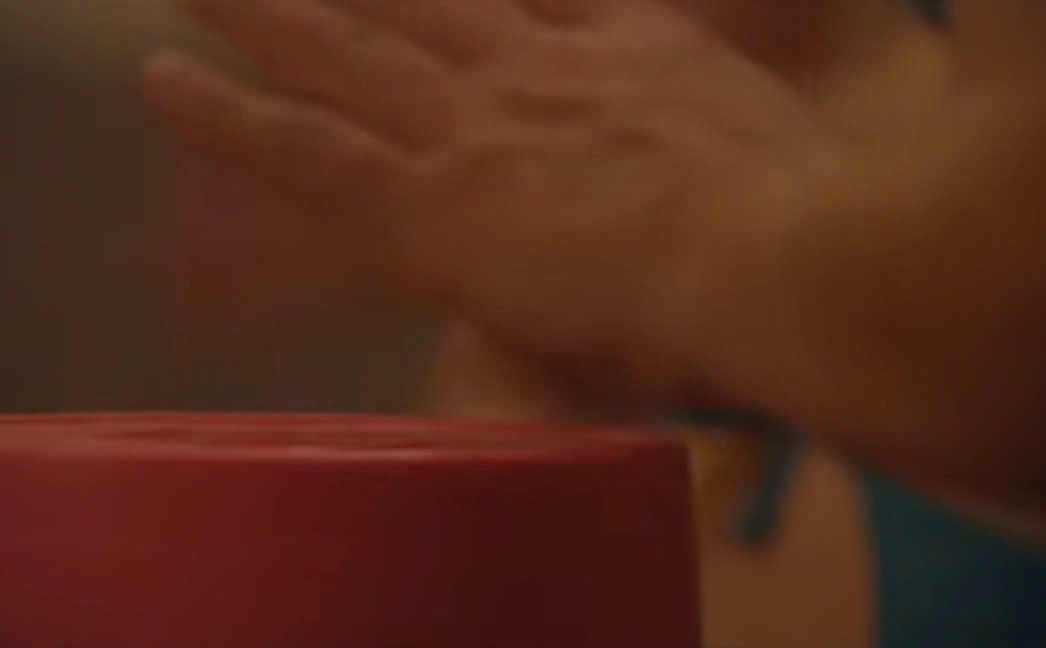

In [ ]:
Image.fromarray(allframe[2],'RGB')